In [29]:
import math
import copy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.api import SARIMAX
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False 
sns.mpl.rc('figure',figsize=(20, 6))

In [2]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline

In [3]:
%run 8.1-forecasting-methods.ipynb

In [4]:
data_load_second_interval = 5
minute_interval = 1

In [5]:
resample_second_interval = 60

In [6]:
resample_minutes = resample_second_interval / 60

In [7]:
hour_observations = int(60/resample_minutes)
half_hour_observations = int(hour_observations/2)
day_observations = int(60/resample_second_interval*60*24)
three_day_observations = int(60/resample_second_interval*60*24*3)
week_observations = int(60/resample_second_interval*60*24*7)

In [8]:
forecast_minutes = 30

In [9]:
forecast_observations = half_hour_observations

#### Load data

In [10]:
data = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{data_load_second_interval}s.csv")
data['ndt'] = pd.to_datetime(data['ndt'])

In [11]:
data = data.groupby('ndt').sum().resample(f'{resample_second_interval}S').sum()

In [12]:
anomaly_free_data = data.copy()

In [13]:
pd.options.mode.chained_assignment = None 

def mean_range(data, start, end):
    past_start = pd.Timestamp(start) - pd.Timedelta(days=1)
    past_end = pd.Timestamp(end) - pd.Timedelta(days=1)
    future_start = pd.Timestamp(start) + pd.Timedelta(days=1)
    future_end = pd.Timestamp(end) + pd.Timedelta(days=1)
    new_vals = data.loc[past_start:past_end]['count'].values + data.loc[future_start:future_end]['count'].values / 2
    data.loc[start:end]['count'] = new_vals
    return data

In [14]:
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 12:20:00','2019-07-22 13:00:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 08:00:00','2019-07-22 08:13:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 13:45:00','2019-07-22 14:07:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-24 12:58:00','2019-07-24 13:18:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-29 12:20:00','2019-07-29 12:53:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-01 12:58:00','2019-08-01 14:30:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-02 14:20:00','2019-08-02 14:59:00')

#### Test and training split

In [15]:
timespan_start = data.index[0]
training_timestamp = pd.date_range(start=timespan_start, end='2019-07-20 08:42:00', freq=f'{resample_second_interval}S')
training_split = len(data.loc[:training_timestamp[-1]])

In [16]:
training_split

53383

In [17]:
data.index[0]

Timestamp('2019-06-13 07:00:00', freq='60S')

In [18]:
data.index[-1]

Timestamp('2019-08-05 05:59:00', freq='60S')

In [19]:
data.index[training_split] 

Timestamp('2019-07-20 08:43:00', freq='60S')

In [20]:
data.index[training_split] - data.index[0]

Timedelta('37 days 01:43:00')

In [18]:
#data.to_csv('../../data/corrected_m2/total_requests_1min.csv')

In [19]:
#data[training_split:].to_csv('../../data/corrected_m2/total_requests_testing_1min.csv')

<AxesSubplot:xlabel='ndt'>

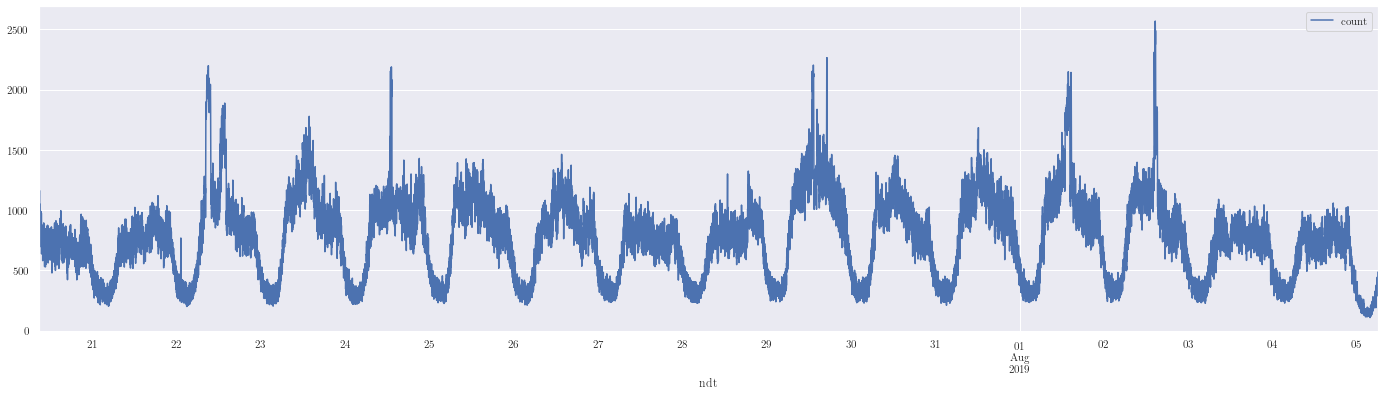

In [21]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
anomaly_free_data[training_split:].plot(ax=ax)

#### Load component forecasts

In [33]:
arimax_sea_forecasts = pd.read_csv('../../data/forecasts/sea_arimax_forecasts.csv', index_col=0, parse_dates=True)
arimax_rt_peak_forecasts = pd.read_csv('../../data/forecasts/peaks_rt_arimax_forecasts.csv', index_col=0, parse_dates=True)
arimax_speculative_peak_forecasts = pd.read_csv('../../data/forecasts/peaks_speculative_arimax_forecasts.csv', index_col=0, parse_dates=True)
gbp_forecasts_speculative = pd.read_csv('../../data/forecasts/peaks_largest_gbp_speculative.csv', index_col=0, parse_dates=True)
gbp_forecasts = pd.read_csv('../../data/forecasts/peaks_largest_gbp.csv', index_col=0, parse_dates=True)

In [34]:
gbp_forecasts_speculative.columns = [f"step_{x}" for x in range(1,31)]
gbp_forecasts.columns = [f"step_{x}" for x in range(1,31)]

In [35]:
largest_peaks_through_time = pd.read_csv('../../data/peaks/largest_peaks.csv', index_col=0, parse_dates=True)
largest_peaks_through_time = pd.DataFrame(largest_peaks_through_time['count'])
largest_peaks_through_time = largest_peaks_through_time[training_split-30:]

In [36]:
largest_peaks_through_time['step_1'] = largest_peaks_through_time['count'].shift()
for i in range(2, 31):
    largest_peaks_through_time[f"step_{i}"] = largest_peaks_through_time[f"step_{i-1}"].shift(-1)
largest_peaks_through_time = largest_peaks_through_time.drop(columns='count')[30:]

In [37]:
largest_peaks_through_time.index = largest_peaks_through_time.index.shift(-1, freq=f'{resample_second_interval}S')

# HTS

In [38]:
summing_matrix_simplified = np.matrix([
    [1, 1, 1], # Total sum
    [1, 0, 0], # Long-living
    [0, 1, 1], # Short-living
    [1, 0, 0], # Long-Living Series only
    [0, 1, 0], # Short-living Remaining Series only
    [0, 0, 1], # Short-living Tracked Series only
])

In [39]:
def hts_forecast(summing_matrix, data, step):
    input_forecast_matrix = np.matrix([x.values[step] for x in data])
    return summing_matrix * input_forecast_matrix

## Strict real-time method - RF

In [40]:
total_rt = []
long_living_rt = []
short_living_rt = []
long_living_only_rt = []
short_living_remaining_rt = []
short_living_tracked_rt = []

for i in range(0, len(arimax_sea_forecasts)):
    forecasts = hts_forecast(summing_matrix_simplified, [arimax_sea_forecasts, arimax_rt_peak_forecasts, gbp_forecasts], i)
    total_rt.append(forecasts[0].A1)
    long_living_rt.append(forecasts[1].A1)
    short_living_rt.append(forecasts[2].A1)
    long_living_only_rt.append(forecasts[3].A1)
    short_living_remaining_rt.append(forecasts[4].A1)
    short_living_tracked_rt.append(forecasts[5].A1)

total_rt = pd.DataFrame(total_rt, index=arimax_sea_forecasts.index)
long_living_rt = pd.DataFrame(long_living_rt, index=arimax_sea_forecasts.index)
short_living_rt = pd.DataFrame(short_living_rt, index=arimax_sea_forecasts.index)
long_living_only_rt = pd.DataFrame(long_living_only_rt, index=arimax_sea_forecasts.index)
short_living_remaining_rt = pd.DataFrame(short_living_remaining_rt, index=arimax_sea_forecasts.index)
short_living_tracked_rt = pd.DataFrame(short_living_tracked_rt, index=arimax_sea_forecasts.index)

In [41]:
#total_rt.to_csv('../../data/forecasts/total_hts_rt.csv')

In [49]:
total_errors = []
for row in total_rt.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = data.loc[row_timestamp+pd.Timedelta(minutes=1):row_timestamp+pd.Timedelta(minutes=30)]
    #break
    total_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
total_errors = pd.DataFrame(total_errors).fillna(0)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

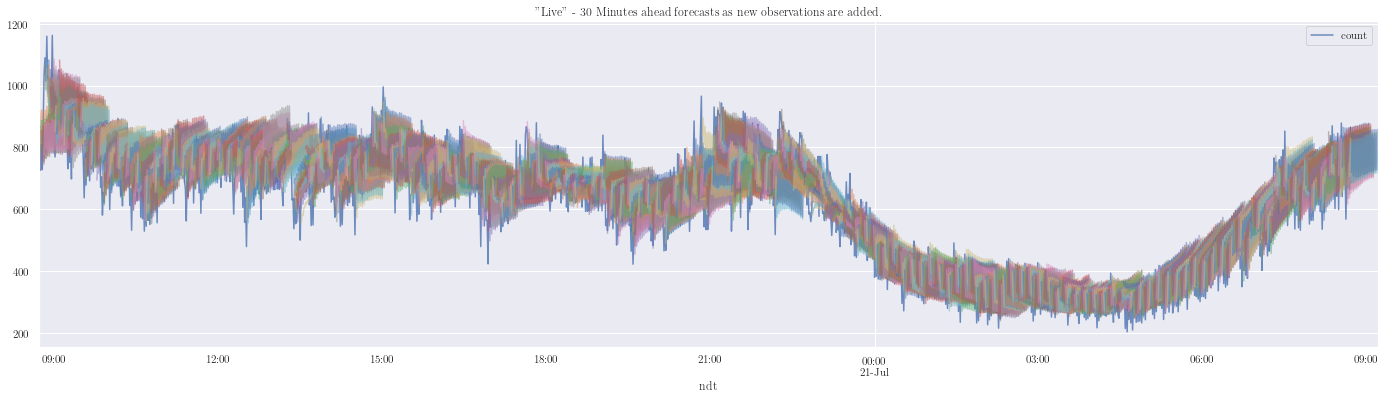

In [48]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in total_rt[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

## Speculative method - RF

In [42]:
total_speculative = []
long_living_speculative = []
short_living_speculative = []
long_living_only_speculative = []
short_living_remaining_speculative = []
short_living_tracked_speculative = []

for i in range(0, len(arimax_sea_forecasts)):
    forecasts = hts_forecast(summing_matrix_simplified, [arimax_sea_forecasts, arimax_speculative_peak_forecasts, gbp_forecasts_speculative], i)
    total_speculative.append(forecasts[0].A1)
    long_living_speculative.append(forecasts[1].A1)
    short_living_speculative.append(forecasts[2].A1)
    long_living_only_speculative.append(forecasts[3].A1)
    short_living_remaining_speculative.append(forecasts[4].A1)
    short_living_tracked_speculative.append(forecasts[5].A1)

total_speculative = pd.DataFrame(total_speculative, index=arimax_sea_forecasts.index)
long_living_speculative = pd.DataFrame(long_living_speculative, index=arimax_sea_forecasts.index)
short_living_speculative = pd.DataFrame(short_living_speculative, index=arimax_sea_forecasts.index)
long_living_only_speculative = pd.DataFrame(long_living_only_speculative, index=arimax_sea_forecasts.index)
short_living_remaining_speculative = pd.DataFrame(short_living_remaining_speculative, index=arimax_sea_forecasts.index)
short_living_tracked_speculative = pd.DataFrame(short_living_tracked_speculative, index=arimax_sea_forecasts.index)

In [43]:
#total_speculative.to_csv('../../data/forecasts/total_hts_speculative.csv')

In [50]:
total_errors_speculative = []
for row in total_speculative.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = data.loc[row_timestamp+pd.Timedelta(minutes=1):row_timestamp+pd.Timedelta(minutes=30)]
    #break
    total_errors_speculative.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
total_errors_speculative = pd.DataFrame(total_errors_speculative).fillna(0)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

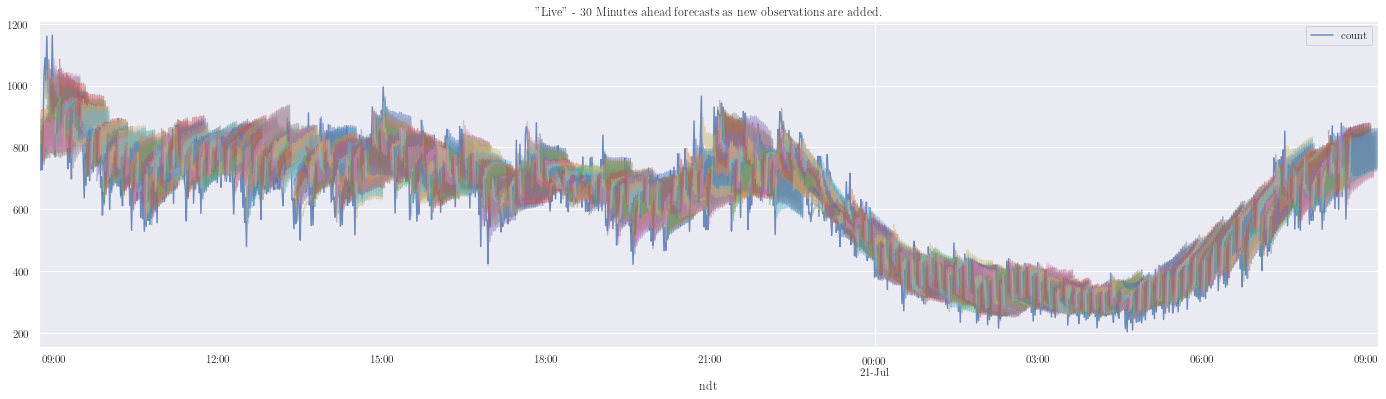

In [52]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in total_speculative[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

## Oracle method

In [44]:
total_oracle = []
long_living_oracle = []
short_living_oracle = []
long_living_only_oracle = []
short_living_remaining_oracle = []
short_living_tracked_oracle = []

for i in range(0, len(arimax_sea_forecasts)):
    forecasts = hts_forecast(summing_matrix_simplified, [arimax_sea_forecasts, arimax_rt_peak_forecasts, largest_peaks_through_time], i)
    total_oracle.append(forecasts[0].A1)
    long_living_oracle.append(forecasts[1].A1)
    short_living_oracle.append(forecasts[2].A1)
    long_living_only_oracle.append(forecasts[3].A1)
    short_living_remaining_oracle.append(forecasts[4].A1)
    short_living_tracked_oracle.append(forecasts[5].A1)

total_oracle = pd.DataFrame(total_oracle, index=arimax_sea_forecasts.index)
long_living_oracle = pd.DataFrame(long_living_oracle, index=arimax_sea_forecasts.index)
short_living_oracle = pd.DataFrame(short_living_oracle, index=arimax_sea_forecasts.index)
long_living_only_oracle = pd.DataFrame(long_living_only_oracle, index=arimax_sea_forecasts.index)
short_living_remaining_oracle = pd.DataFrame(short_living_remaining_oracle, index=arimax_sea_forecasts.index)
short_living_tracked_oracle = pd.DataFrame(short_living_tracked_oracle, index=arimax_sea_forecasts.index)

In [45]:
#total_oracle.to_csv('../../data/forecasts/total_hts_oracle.csv')

In [51]:
errors_oracle = []
for row in total_oracle.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = data.loc[row_timestamp+pd.Timedelta(minutes=1):row_timestamp+pd.Timedelta(minutes=30)]
    #break
    errors_oracle.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
errors_oracle = pd.DataFrame(errors_oracle).fillna(0)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

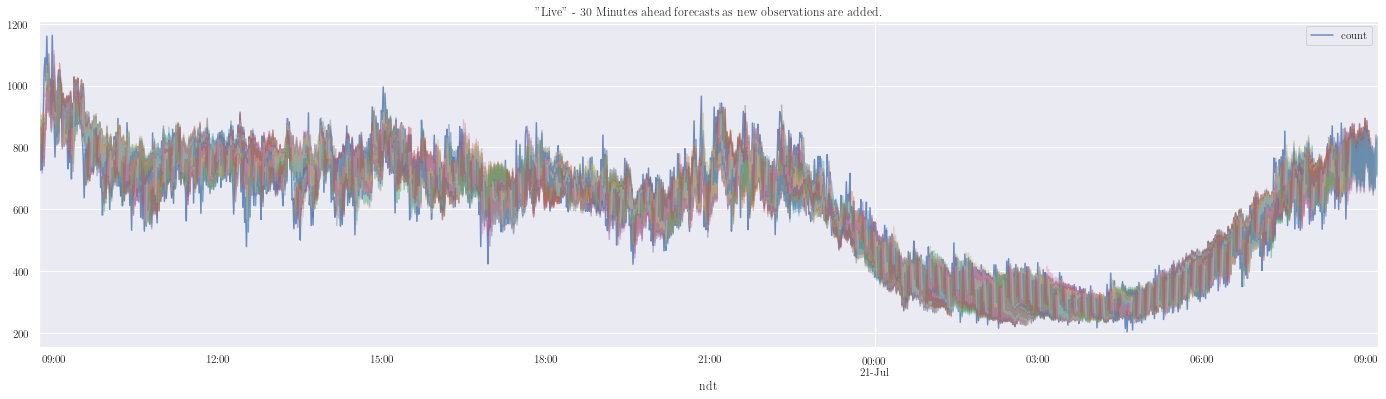

In [57]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in total_oracle[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

## Naive Method

In [54]:
naive_mod = naive_method(data[:training_split])

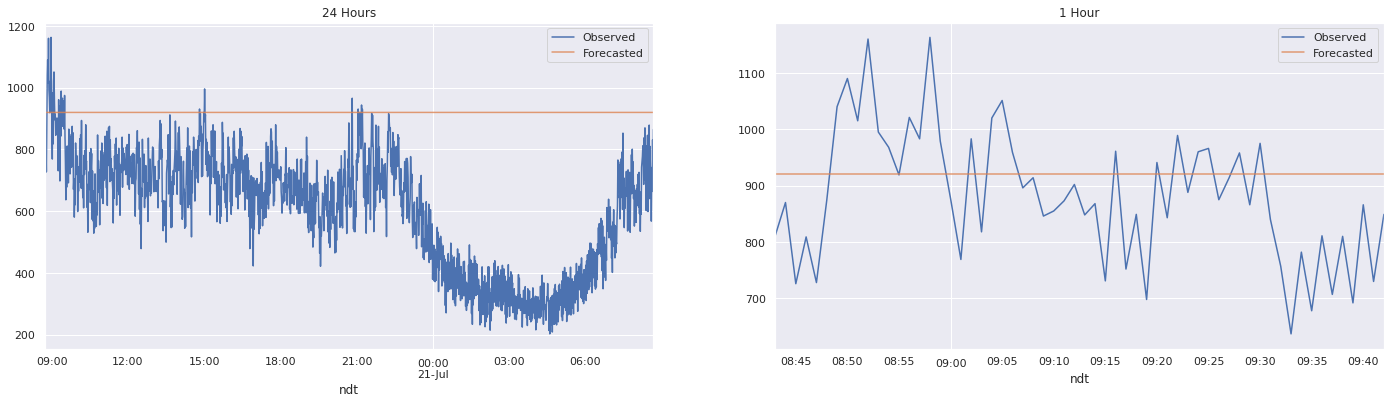

In [36]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(naive_mod.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+hour_observations], pd.Series(naive_mod.forecast(hour_observations)), ax[1])

In [53]:
naive_mod_forecasts = forecast_n_steps(data, naive_mod, training_split, half_hour_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 60 Minutes ahead forecasts as new observations are added.')

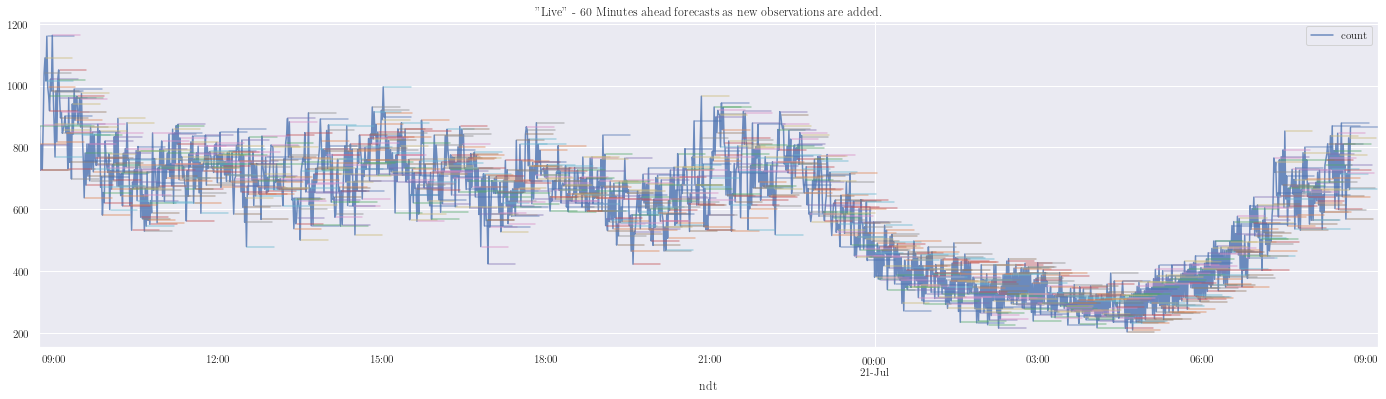

In [61]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in naive_mod_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 60 Minutes ahead forecasts as new observations are added.")

In [55]:
_, naive_errors = error_n_steps(data, naive_mod, training_split, half_hour_observations)

## Average method

In [56]:
average_method_mod = average_method(data[:training_split], half_hour_observations)

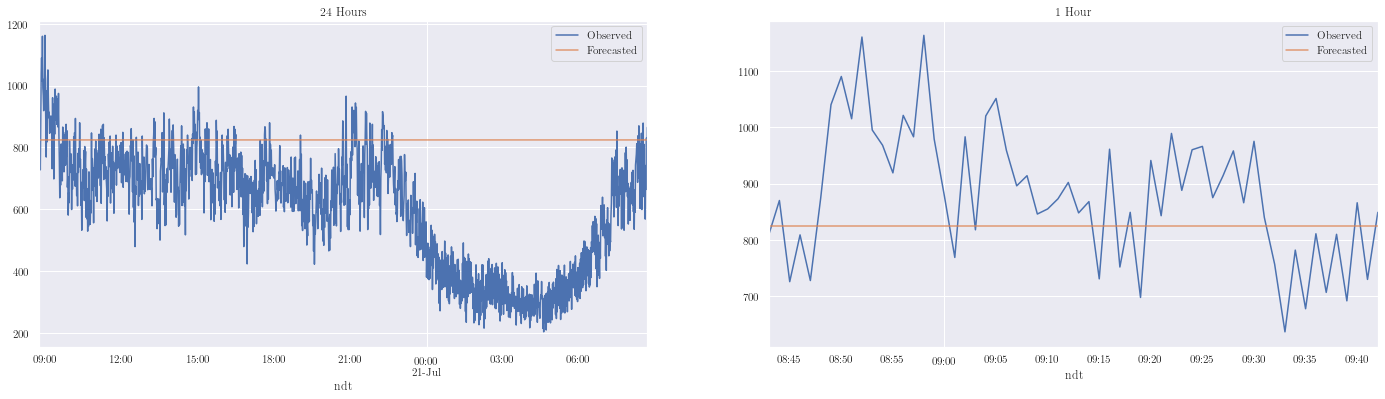

In [63]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(average_method_mod.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+hour_observations], pd.Series(average_method_mod.forecast(hour_observations)), ax[1])

In [64]:
average_method_forecasts = forecast_n_steps(data, average_method_mod, training_split, half_hour_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

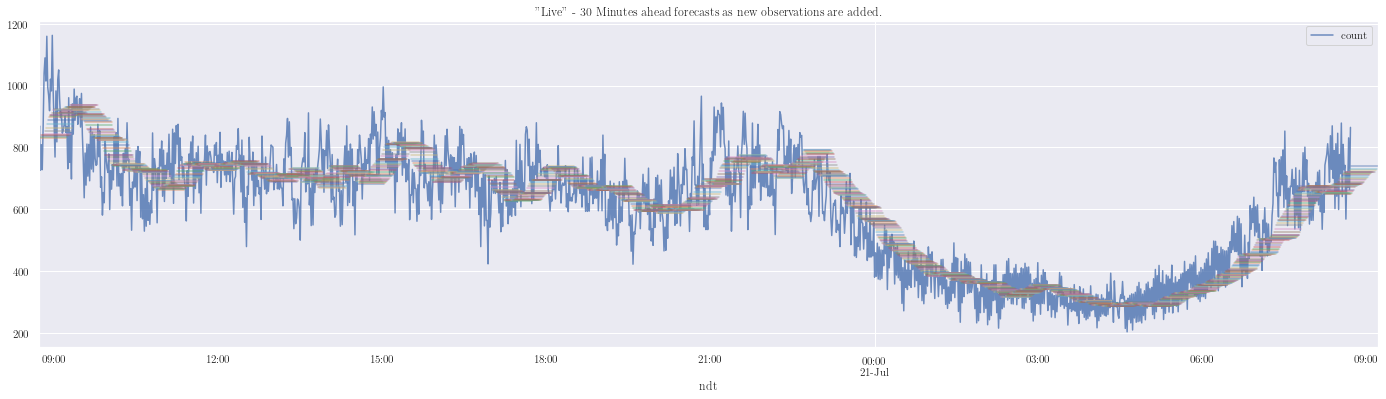

In [65]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in average_method_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

In [57]:
_, average_errors = error_n_steps(data, average_method_mod, training_split, half_hour_observations)

## Seasonal Naive Method (24-hour)

In [58]:
seasonal_naive_mod = seasonal_naive_method(data[:training_split], day_observations)

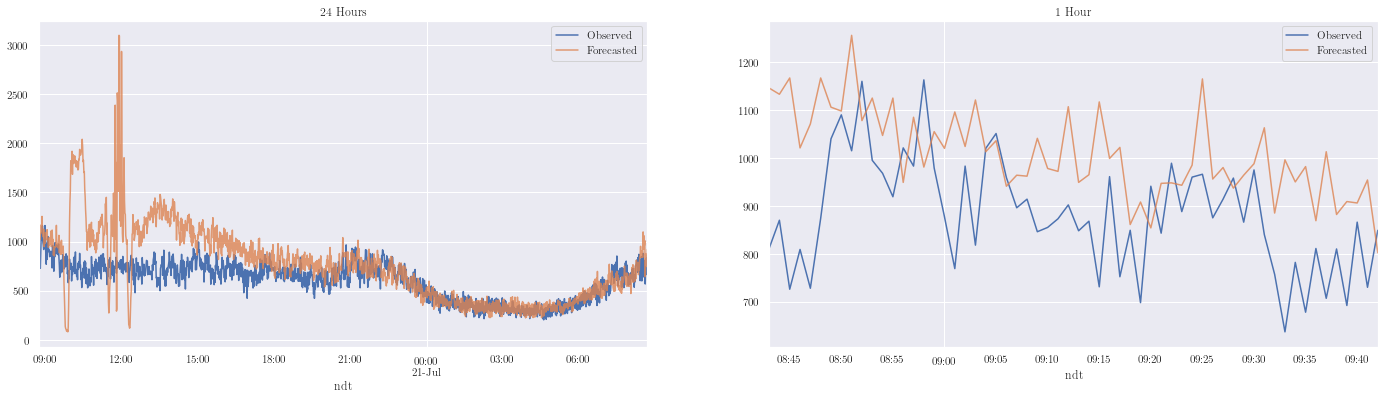

In [67]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(seasonal_naive_mod.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+hour_observations], pd.Series(seasonal_naive_mod.forecast(hour_observations)), ax[1])

In [68]:
seasonal_naive_forecasts = forecast_n_steps(data, seasonal_naive_mod, training_split, half_hour_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

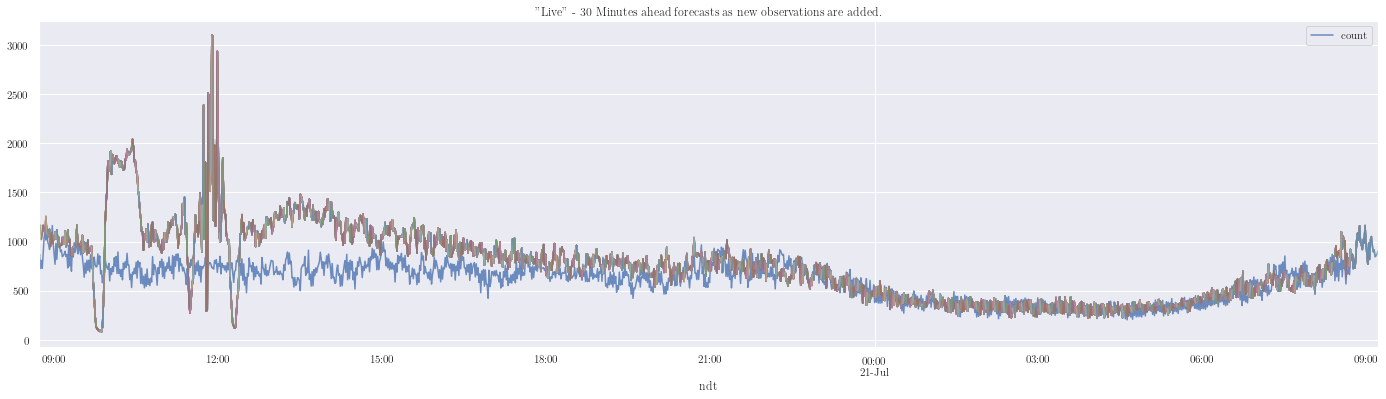

In [69]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in seasonal_naive_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

In [59]:
_, seasonal_naive_errors = error_n_steps(data, seasonal_naive_mod, training_split, half_hour_observations)

## AR(1)

In [60]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.api import SARIMAX

In [46]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html

In [61]:
ar_1_mod = SARIMAX(data[:training_split], order=(1,0,0), trend='c')
ar_1_res = ar_1_mod.fit()

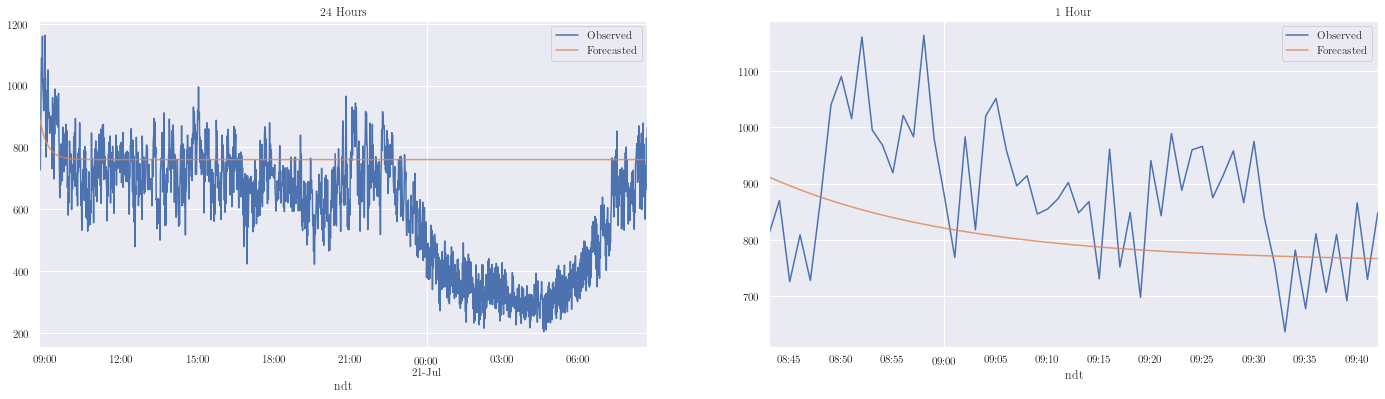

In [72]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(ar_1_res.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+hour_observations], pd.Series(ar_1_res.forecast(hour_observations)), ax[1])

In [73]:
ar_1_forecasts = forecast_n_steps(data, ar_1_res, training_split, hour_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 60 Minutes ahead forecasts as new observations are added.')

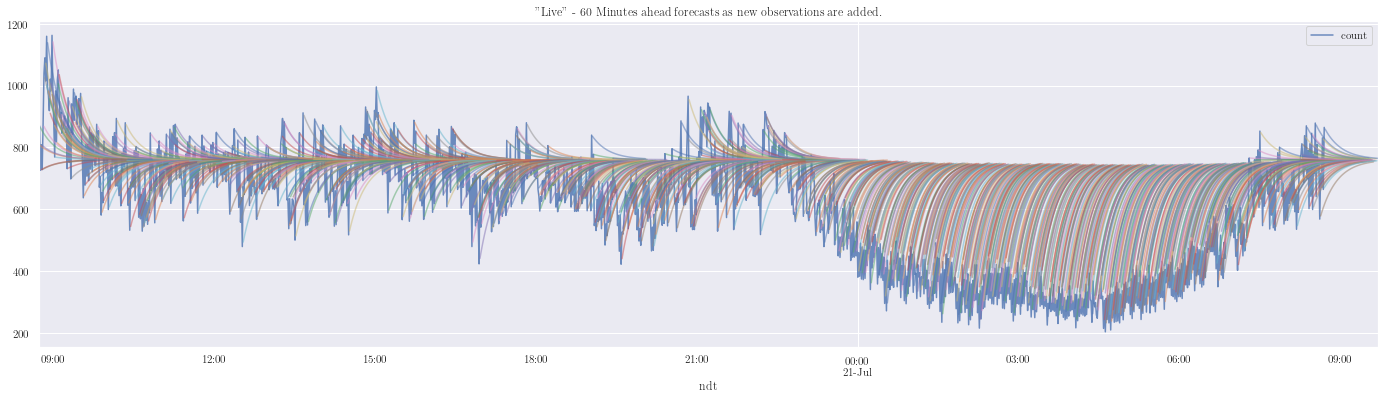

In [74]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in ar_1_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=60),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 60 Minutes ahead forecasts as new observations are added.")

In [62]:
_, ar1_errors = error_n_steps(data, ar_1_res, training_split, hour_observations)

# TBATS

In [75]:
from tbats import TBATS

In [76]:
tbats_mod = TBATS(seasonal_periods=[day_observations], use_box_cox=False)

In [77]:
tbats_res = tbats_mod.fit(data[:training_split])

In [52]:
tbats_res.summary()

'Use Box-Cox: False\nUse trend: False\nUse damped trend: False\nSeasonal periods: []\nSeasonal harmonics []\nARMA errors (p, q): (5, 2)\nSmoothing (Alpha): 0.316362\nSeasonal Parameters (Gamma): []\nAR coefficients [-0.56499439  0.4390619   0.06279082 -0.01010538 -0.06043116]\nMA coefficients [0.89399615 0.01540858]\nSeed vector [948.72136722   0.           0.           0.           0.\n   0.           0.           0.        ]\n\nAIC 1033346.252830'

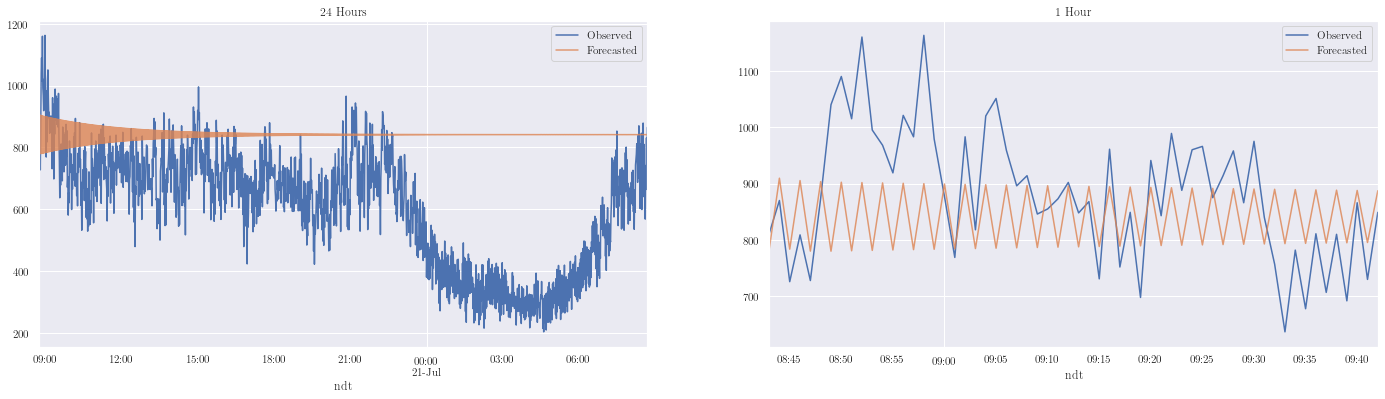

In [78]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(tbats_res.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+hour_observations], pd.Series(tbats_res.forecast(hour_observations)), ax[1])

Text(0.5, 1.0, '"Live" - 60 Minutes ahead forecasts as new observations are added.')

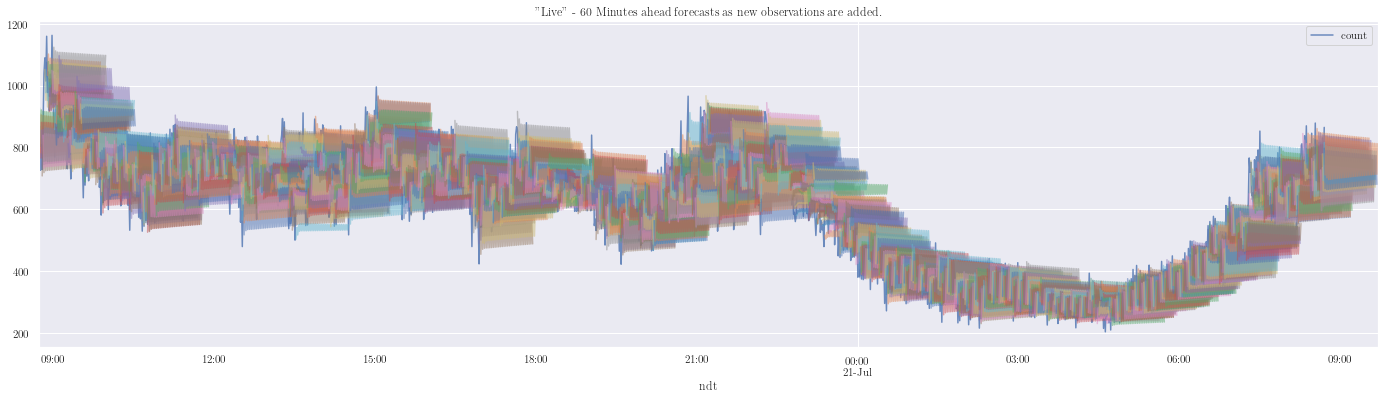

In [79]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

vis_tbats = copy.deepcopy(tbats_res)

pd.Series(vis_tbats.forecast(hour_observations), index=data.index[training_split:training_split+hour_observations]).plot(ax=ax, alpha=0.6)
for i in range(1, day_observations+1): # 24 hour ahead
    vis_tbats.fit(data[:training_split+i])
    pd.Series(vis_tbats.forecast(hour_observations), index=data.index[training_split+i:training_split+i+hour_observations]).plot(ax=ax, alpha=0.5)
ax.set_title("\"Live\" - 60 Minutes ahead forecasts as new observations are added.")

In [53]:
_, tbats_errors = error_n_steps(data, copy.deepcopy(tbats_res), training_split, hour_observations)

## ARIMA with Fourier Terms

In [23]:
from pmdarima.preprocessing import FourierFeaturizer
import pmdarima as pm

In [ ]:
resulting_models = []
for d_k in range(1, 12):
        daily_transformation = FourierFeaturizer(m=day_observations, k=d_k)
        _, exog_d = daily_transformation.fit_transform(data[:training_split])
        print(d_k)
        ft_fit = pm.auto_arima(data[:training_split],
                             start_q = 2,
                             max_q = 20,
                             start_p = 2,
                             max_p = 20,
                             D = None,
                             exogenous=exog_d,
                             max_order = 30,
                             seasonal = False,
                             information_criterion = 'aic',
                             stepwise = True, # n_jobs = 16
                             trace = 2,
                             cov_type=None
                            )
        resulting_models.append(ft_fit)

1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=603851.642, Time=90.51 sec
First viable model found (603851.642)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=653867.238, Time=3.76 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=617882.072, Time=4.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=630699.158, Time=31.96 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=653865.245, Time=27.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=604406.066, Time=91.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=604985.569, Time=101.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=603651.847, Time=157.23 sec
New best model found (603651.847 < 603851.642)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=604280.984, Time=129.82 sec
Near non-invertible roots for order (4, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=200.27 sec
 ARIMA(3,1,3)(0,0,0)[0] int

In [62]:
resulting_models

[ARIMA(order=(6, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(6, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(8, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(8, 1, 4), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(7, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(8, 1, 4), scoring_args={}, suppress_warnings=True,
       with_in

In [59]:
smallest_aic = min(resulting_models, key=lambda x: x.aic())

In [60]:
smallest_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53383
Model:               SARIMAX(8, 1, 4)   Log Likelihood             -301655.134
Date:                Wed, 10 Mar 2021   AIC                         603374.268
Time:                        08:53:39   BIC                         603658.596
Sample:                             0   HQIC                        603463.062
                              - 53383                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0050      0.033      0.152      0.879      -0.060       0.070
FOURIER_S1440-0   303.1424     40.181      7.544      0.000     224.388     381.896
FOURIER_C1440-0  -108.2257     47.235     -2.291      0.022    -200.804     -15.647
FOURIER_S1440-1   126.7265     21.768      5.822      0.000      84.062     169.391
FOURIER_C1440-1    38.7534     22.424      1.728      0.084      -5.197      82.703
FOURIER_S1440-2   -13.7617     14.701     -0.936      0.349     -42.576      15.053
FOURIER_C1440-2    54.8913     15.139      3.626      0.000      25.219      84.564
FOURIER_S1440-3    40.1578     11.405      3.521      0.000      17.804      62.512
FOURIER_C1440-3     1.2085     11.364      0.106      0.915     -21.064      23.481
FOURIER_S1440-4    31.4206      9.232      3.403      0.001      13.325      49.516
FOURIER_C1440-4    12.2337      9.360      1.307      0.191      -6.112      30.580
FOURIER_S1440-5    -9.4267      7.868     -1.198      0.231     -24.848       5.994
FOURIER_C1440-5     5.0061      7.948      0.630      0.529     -10.571      20.583
FOURIER_S1440-6     0.2593      6.948      0.037      0.970     -13.359      13.878
FOURIER_C1440-6    -0.5240      6.788     -0.077      0.938     -13.828      12.780
FOURIER_S1440-7     2.4367      5.919      0.412      0.681      -9.163      14.037
FOURIER_C1440-7     8.0163      6.018      1.332      0.183      -3.778      19.810
FOURIER_S1440-8     5.6730      5.001      1.134      0.257      -4.129      15.475
FOURIER_C1440-8     2.0631      4.966      0.415      0.678      -7.670      11.796
ar.L1               0.5144      0.017     29.762      0.000       0.481       0.548
ar.L2               0.3194      0.018     17.758      0.000       0.284       0.355
ar.L3              -0.6658      0.017    -39.132      0.000      -0.699      -0.632
ar.L4               0.4741      0.014     33.373      0.000       0.446       0.502
ar.L5               0.0398      0.004      9.573      0.000       0.032       0.048
ar.L6               0.0356      0.003     13.290      0.000       0.030       0.041
ar.L7               0.0014      0.003      0.524      0.600      -0.004       0.007
ar.L8               0.0357      0.002     15.441      0.000       0.031       0.040
ma.L1              -0.8727      0.018    -49.472      0.000      -0.907      -0.838
ma.L2              -0.0898      0.019     -4.725      0.000      -0.127      -0.053
ma.L3               0.6233      0.015     40.631      0.000       0.593       0.653
ma.L4              -0.5765      0.017    -34.408      0.000      -0.609      -0.544
sigma2           4749.6042      9.231    514.509      0.000    4731.511    4767.697
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           5477497.78
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew

In [61]:
print(smallest_aic, smallest_aic.aic())

 ARIMA(8,1,4)(0,0,0)[0] intercept 603374.2682077729


In [ ]:
# K = 9

### Selected model

In [26]:
fourier_dp = DeterministicProcess(data.index, period=day_observations, fourier=9)
exog_fourier = fourier_dp.in_sample()

In [27]:
exog_fourier = exog_fourier.append(
                fourier_dp.out_of_sample(hour_observations,
                                       forecast_index=pd.date_range(
                                               start=exog_fourier.index[-1]+pd.Timedelta(minutes=1),
                                               periods=hour_observations,
                                               freq=f"{resample_second_interval}S")))

In [30]:
arimax_mod = SARIMAX(data[:training_split], order=(8, 1, 4), exog=exog_fourier[:training_split], trend='c')
arimax_res = arimax_mod.fit()
print(arimax_res.summary())

/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                53383
Model:               SARIMAX(8, 1, 4)   Log Likelihood             -301655.258
Date:                Wed, 07 Apr 2021   AIC                         603374.516
Time:                        21:24:43   BIC                         603658.843
Sample:                    06-13-2019   HQIC                        603463.310
                         - 07-20-2019                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0060      0.032      0.189      0.850      -0.056       0.068
sin(1,1440)   303.6116     39.763      7.636      0.000     225.678     381.545
cos(1,1440)  -106.9023     46.851     -2.282    

In [68]:
#joblib.dump(arimax_res, open(f'../../models/arimax_combined_{minute_interval}_{resample_second_interval}', 'wb'))

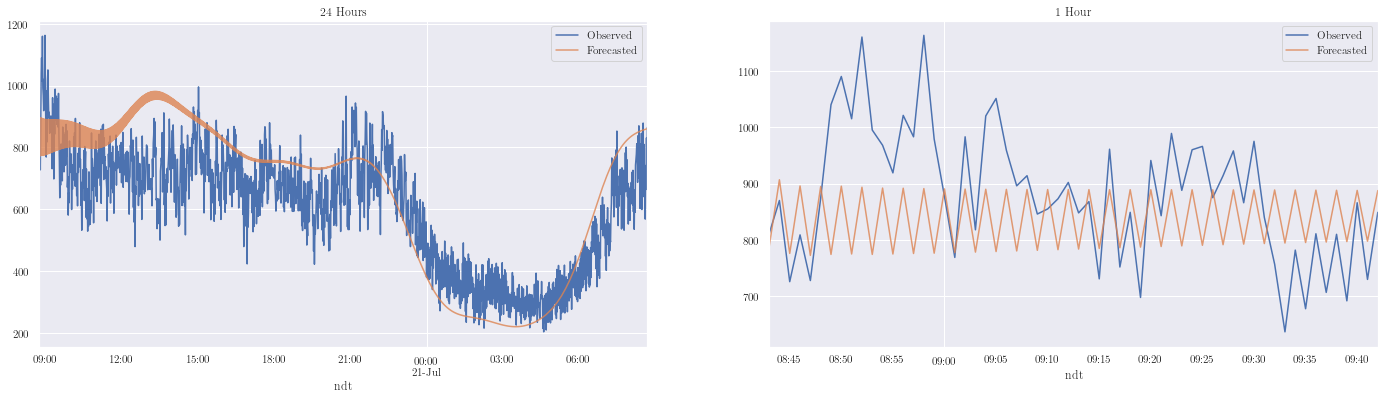

In [84]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(data[training_split:training_split+day_observations],
              pd.Series(arimax_res.forecast(
                    day_observations,
                    exog=exog_fourier[training_split:training_split+day_observations])),
              ax[0])
showcase_zoom(data[training_split:training_split+hour_observations],
              pd.Series(arimax_res.forecast(
                    hour_observations,
                    exog=exog_fourier[training_split:training_split+hour_observations])),
              ax[1])

In [ ]:
arimax_timestamps = []
arimax_forecasts = []
for step in range(training_split, len(anomaly_free_data)):
    clear_output(wait=True)
    print("Step: ", step + 1, "-", len(anomaly_free_data), "; %:", (step + 1)/len(anomaly_free_data), end='\r')
    data_extended = data[step:step+1]
    arimax_timestamps.append(data_extended.index[0])
    arimax_res = arimax_res.append(data_extended, exog=exog_fourier[step:step+1])
    forecast_exog = exog_fourier[step:step+forecast_observations]
    arimax_forecasts.append(arimax_res.forecast(min(forecast_observations, len(forecast_exog)), exog=forecast_exog).values)
arimax_forecasts = pd.DataFrame(index=arimax_timestamps, data=arimax_forecasts, columns=[f"step_{x}" for x in range(1, forecast_observations+1)])
del arimax_timestamps

Text(0.5, 1.0, '"Live" - 60 Minutes ahead forecasts as new observations are added.')

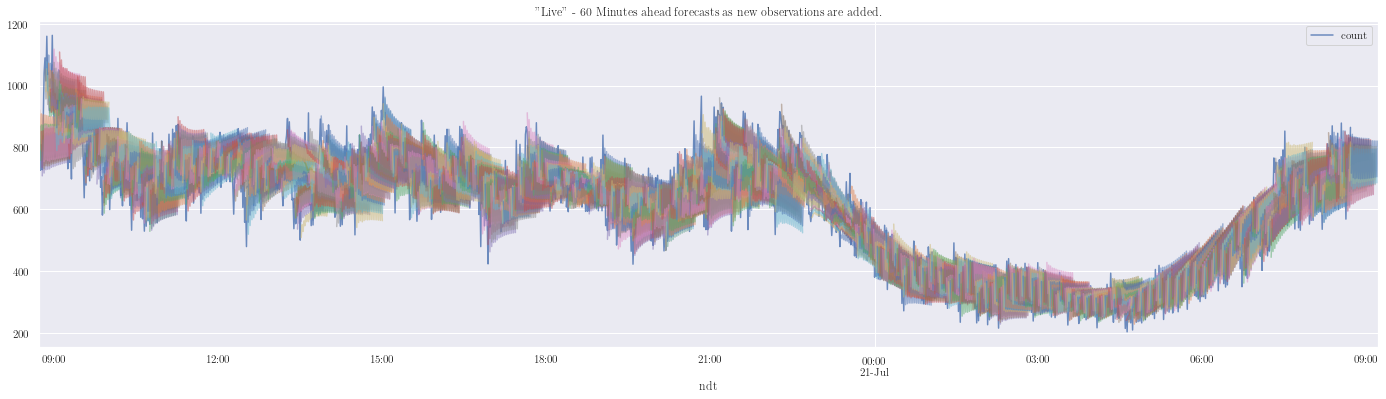

In [87]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in arimax_forecasts[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)
ax.set_title("\"Live\" - 60 Minutes ahead forecasts as new observations are added.")

In [ ]:
#arimax_forecasts.to_csv('../../data/forecasts/total_arimax_forecasts.csv')

In [85]:
arimax_forecasts = pd.read_csv('../../data/forecasts/total_arimax_forecasts.csv', index_col=0, parse_dates=True)

In [63]:
arimax_errors = []
for row in arimax_forecasts.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = data.loc[row_timestamp+pd.Timedelta(minutes=1):row_timestamp+pd.Timedelta(minutes=30)]
    arimax_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
arimax_errors = pd.DataFrame(arimax_errors).fillna(0)

# Evaluation

In [64]:
arimax_mse, arimax_rmse = rmse_forecasts(arimax_errors)
naive_mse, naive_rmse = rmse_forecasts(naive_errors)
average_mse, average_rmse = rmse_forecasts(average_errors)
seasonal_naive_mse, seasonal_naive_rmse = rmse_forecasts(seasonal_naive_errors)
ar1_mse, ar1_rmse = rmse_forecasts(ar1_errors)
#tbats_mse, tbats_rmse = rmse_forecasts(tbats_errors)
total_rt_mse, total_rt_rmse = rmse_forecasts(total_errors)
total_speculative_mse, total_speculative_rmse = rmse_forecasts(total_errors_speculative)
oracle_mse, oracle_rmse = rmse_forecasts(errors_oracle)

In [90]:
#forecast_errors['total_speculative_mse'] = total_speculative_mse
#forecast_errors['total_speculative_rmse'] = total_speculative_rmse
#forecast_errors['total_rt_mse'] = total_rt_mse
#forecast_errors['total_rt_rmse'] = total_rt_rmse

In [66]:
forecast_errors = pd.DataFrame()
forecast_errors['naive_mse'] = naive_mse
forecast_errors['naive_rmse'] = naive_rmse
forecast_errors['average_mse'] = average_mse
forecast_errors['average_rmse'] = average_rmse
forecast_errors['seasonal_naive_mse'] = seasonal_naive_mse
forecast_errors['seasonal_naive_rmse'] = seasonal_naive_rmse
forecast_errors['ar1_mse'] = ar1_mse
forecast_errors['ar1_rmse'] = ar1_rmse
forecast_errors['arimax_mse'] = arimax_mse
forecast_errors['arimax_rmse'] = arimax_rmse
#forecast_errors['tbats_mse'] = tbats_mse
#forecast_errors['tbats_rmse'] = tbats_rmse
forecast_errors['total_rt_mse'] = total_rt_mse
forecast_errors['total_rt_rmse'] = total_rt_rmse
forecast_errors['total_speculative_mse'] = total_speculative_mse
forecast_errors['total_speculative_rmse'] = total_speculative_rmse
forecast_errors['oracle_mse'] = oracle_mse
forecast_errors['oracle_rmse'] = oracle_rmse

In [41]:
#forecast_errors.to_csv("../../data/forecasts/total_errors.csv")

In [65]:
forecast_errors = pd.read_csv("../../data/forecasts/total_errors.csv", index_col=0)

Text(0.5, 1.0, 'Speculative method residua distribution')

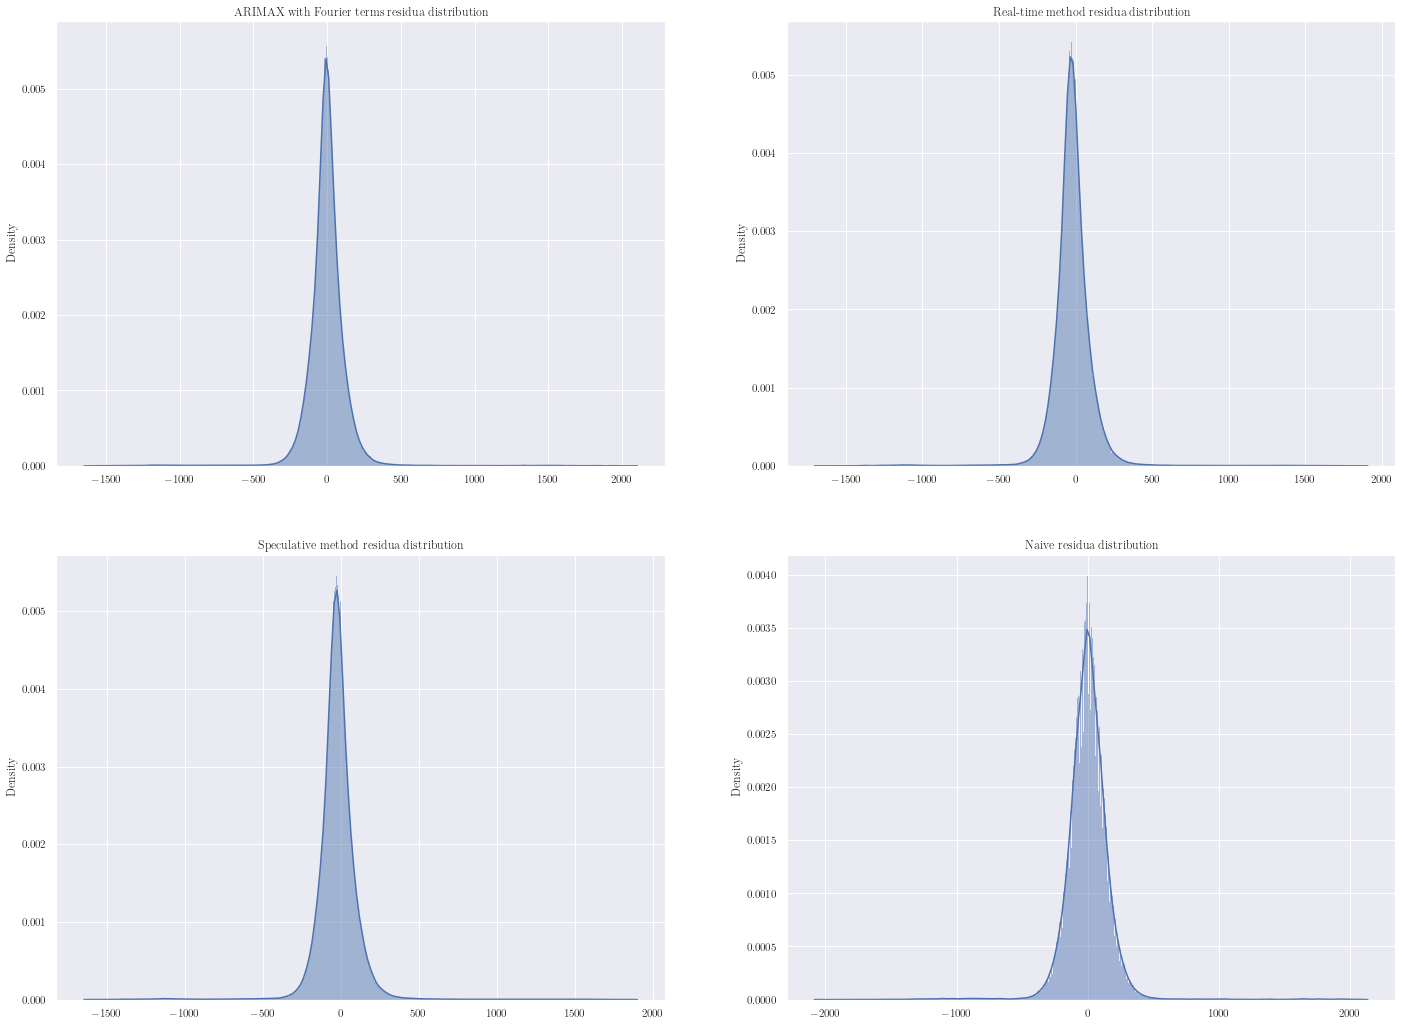

In [107]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(24, 18)

arimax_residues = pd.Series(arimax_errors.values.flatten())
#tbats_residues = pd.Series(tbats_errors.values.flatten())
#ar1_residues = pd.Series(ar1_errors.values.flatten())
naive_residues = pd.Series(naive_errors.values.flatten())
#seasonal_naive_residues = pd.Series(seasonal_naive_errors.values.flatten())
#average_residues = pd.Series(average_errors.values.flatten())
total_rt_residues = pd.Series(total_errors.values.flatten())
total_speculative_residues = pd.Series(total_errors_speculative.values.flatten())


sns.histplot(arimax_residues, ax=ax[0][0], stat='density', kde=True)
ax[0][0].set_title("ARIMAX with Fourier terms residua distribution")

#sns.histplot(tbats_residues, ax=ax[0][1], stat='density', kde=True)
#ax[0][1].set_title("TBATS residua distribution")

#sns.histplot(ar1_residues, ax=ax[1][0], stat='density', kde=True)
#ax[1][0].set_title("AR(1) residua distribution")

sns.histplot(naive_residues, ax=ax[1][1], stat='density', kde=True)
ax[1][1].set_title("Naive residua distribution")

#sns.histplot(seasonal_naive_residues, ax=ax[2][0], stat='density', kde=True)
#ax[2][0].set_title("Seasonal naive residua distribution")

#sns.histplot(average_residues, ax=ax[2][1], stat='density', kde=True)
#ax[2][1].set_title("Average residua distribution")

sns.histplot(total_rt_residues, ax=ax[0][1], stat='density', kde=True)
ax[0][1].set_title("Real-time method residua distribution")

sns.histplot(total_speculative_residues, ax=ax[1][0], stat='density', kde=True)
ax[1][0].set_title("Speculative method residua distribution")

In [111]:
forecast_errors.index = data[-len(total_rt_mse):].index

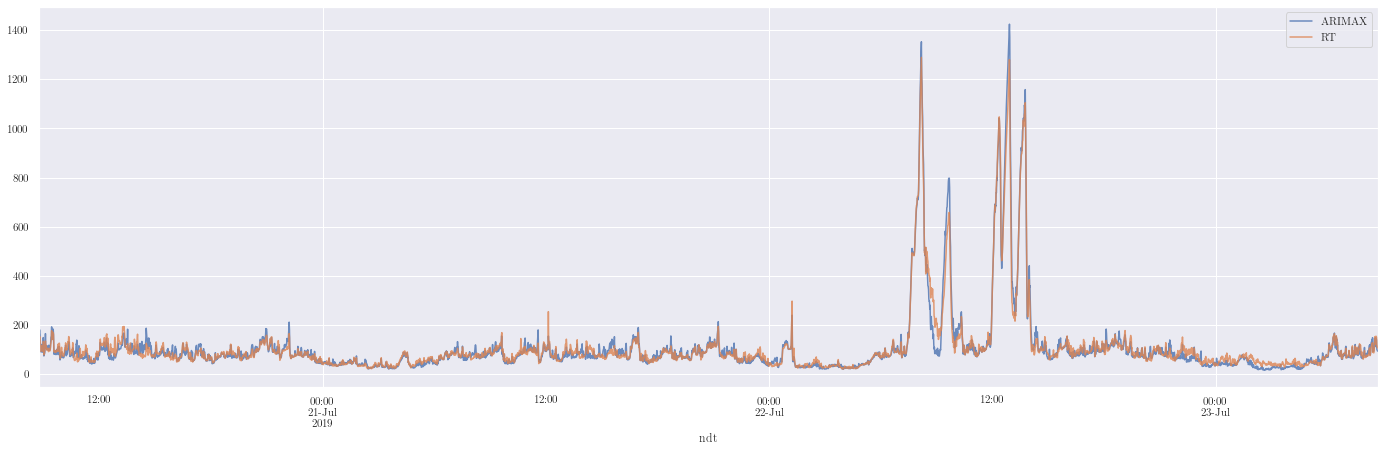

In [119]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 7)

#naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
#average_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
#seasonal_naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
#ar1_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
forecast_errors['arimax_rmse'][:day_observations*3].plot(ax=ax, alpha=0.8)
#tbats_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
forecast_errors['total_rt_rmse'][:day_observations*3].plot(ax=ax, alpha=0.8)
#total_speculative_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
ax.legend([ "ARIMAX", "RT", ]) #"Naive", "Average", "Seasonal Naive", "AR(1)", "TBATS","Speculative"

In [ ]:
#tbats_rmse.index = data[-len(tbats_mse):].index
#arimax_rmse.index = data[-len(arimax_mse):].index
#naive_rmse.index = data[-len(naive_rmse):].index
#average_rmse.index = data[-len(average_rmse):].index
#seasonal_naive_rmse.index = data[-len(seasonal_naive_rmse):].index
#ar1_rmse.index = data[-len(ar1_rmse):].index
#total_rt_rmse.index = data[-len(total_rt_rmse):].index
#total_speculative_rmse.index = data[-len(total_speculative_rmse):].index
#oracle_rmse.index = data[-len(oracle_rmse):].index

In [6]:
results = pd.DataFrame(
            data=np.array([
                forecast_errors['tbats_rmse'].sum(),
                forecast_errors['tbats_mse'].sum(),
                forecast_errors['arimax_rmse'].sum(),
                forecast_errors['arimax_mse'].sum(),
                forecast_errors['naive_rmse'].sum(),
                forecast_errors['naive_mse'].sum(),
                forecast_errors['seasonal_naive_rmse'].sum(),
                forecast_errors['seasonal_naive_mse'].sum(),
                forecast_errors['average_rmse'].sum(),
                forecast_errors['average_mse'].sum(),
                forecast_errors['ar1_rmse'].sum(),
                forecast_errors['ar1_mse'].sum(),
                forecast_errors['total_rt_rmse'].sum(),
                forecast_errors['total_rt_mse'].sum(),
                forecast_errors['total_speculative_rmse'].sum(),
                forecast_errors['total_speculative_mse'].sum(),
                forecast_errors['oracle_rmse'].sum(),
                forecast_errors['oracle_mse'].sum()
            ])
                .reshape(1, -1),
            columns = ['tbats_rmse','tbats_mse',
                       'arimax_rmse','arimax_mse',
                       'naive_rmse', 'naive_mse',
                       'seasonal_naive_rmse', 'seasonal_naive_mse',
                       'average_rmse','average_mse',
                       'ar1_rmse','ar1_mse',
                       'total_rt_rmse','total_rt_mse',
                       'total_speculative_rmse', 'total_speculative_mse',
                       'oracle_rmse', 'oracle_mse'
                      ])

In [114]:
results

tbats_rmse     tbats_mse   arimax_rmse    arimax_mse    naive_rmse  \
0  4.540825e+06  1.249225e+09  2.329116e+06  5.544129e+08  3.045174e+06   

      naive_mse  seasonal_naive_rmse  seasonal_naive_mse  average_rmse  \
0  7.593509e+08         4.696929e+06        1.833078e+09  2.863069e+06   

    average_mse      ar1_rmse       ar1_mse  total_rt_rmse  total_rt_mse  \
0  7.599335e+08  5.203650e+06  1.595250e+09   2.368174e+06  5.188046e+08   

   total_speculative_rmse  total_speculative_mse   oracle_rmse    oracle_mse  
0            2.363128e+06           5.181409e+08  2.020370e+06  3.447321e+08

In [115]:
for col in results:
    print(col, '{0:.10f}'.format(results[col][0]))

tbats_rmse 4540824.8714767592
tbats_mse 1249224870.1352810860
arimax_rmse 2329115.6085412763
arimax_mse 554412927.2035443783
naive_rmse 3045173.6201065420
naive_mse 759350872.2195601463
seasonal_naive_rmse 4696929.0652623363
seasonal_naive_mse 1833078140.0419998169
average_rmse 2863068.6051397761
average_mse 759933524.9221837521
ar1_rmse 5203650.1529250825
ar1_mse 1595250062.1606931686
total_rt_rmse 2368173.5208410858
total_rt_mse 518804600.1308946609
total_speculative_rmse 2363128.3978415309
total_speculative_mse 518140866.4712865949
oracle_rmse 2020369.7896163641
oracle_mse 344732087.3104068041


In [7]:
for col in results:
    mean_error = results[col][0]/len(forecast_errors)
    print("mean", col, '{0:.10f}'.format(mean_error))
    results[f"mean_{col}"] = mean_error

mean tbats_rmse 198.4886511115
mean tbats_mse 54606.1489764952
mean arimax_rmse 101.8103601233
mean arimax_mse 24234.5118330001
mean naive_rmse 133.1107059539
mean naive_mse 33192.7644454937
mean seasonal_naive_rmse 205.3122815606
mean seasonal_naive_mse 80127.5578109892
mean average_rmse 125.1505269546
mean average_mse 33218.2333751009
mean ar1_rmse 227.4620865028
mean ar1_mse 69731.6108825761
mean total_rt_rmse 101.3207068496
mean total_rt_mse 22766.6169417825
mean total_speculative_rmse 100.9678345575
mean total_speculative_mse 22655.4232146439
mean oracle_rmse 88.3144551128
mean oracle_mse 15068.9376802206


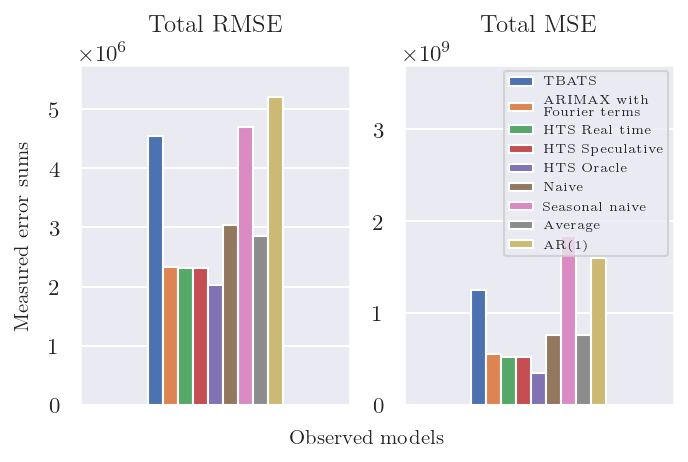

In [8]:
fig, ax = plt.subplots(1, 2, tight_layout=False, dpi=150)
fig.set_size_inches(w=5.10686, h=3)

#fig.set_size_inches(8, 4)



results[['tbats_rmse', 'arimax_rmse','total_rt_rmse',
         'total_speculative_rmse', 'oracle_rmse',
         'naive_rmse', 'seasonal_naive_rmse',
         'average_rmse', 'ar1_rmse']].plot(kind='bar', ax=ax[0])#, color=sns.color_palette("muted", n_colors=8))

ax[0].set_title("Total RMSE", pad=16)

ax[0].get_xaxis().set_ticks([])
#ax[0].set_xlabel("Models")


ax[0].set_ylim(ymax=5750000)


results[['tbats_mse', 'arimax_mse', 'total_rt_mse',
         'total_speculative_mse', 'oracle_mse',
         'naive_mse', 'seasonal_naive_mse',
         'average_mse', 'ar1_mse' 
        ]].plot(kind='bar', ax=ax[1])

ax[1].set_title("Total MSE", pad=16)
ax[0].get_legend().remove()
            
ax[1].legend(["TBATS", "ARIMAX with\nFourier terms", 'HTS Real time',
              'HTS Speculative',  'HTS Oracle',
              "Naive", "Seasonal naive",
              "Average", 'AR(1)'], fontsize="xx-small", loc='upper right')
            
ax[1].get_xaxis().set_ticks([])
ax[1].set_ylim(ymax=3700000000)
#ax[1].set_xlabel("Models")

fig.text(0.5, 0.04, 'Observed models', ha='center')
fig.text(0.04, 0.5, 'Measured error sums', va='center', rotation='vertical')


#tikzplotlib.save("test.tex")
fig.savefig('../../plots/text-plots/8-1min-hts-combined-rmse.pgf')

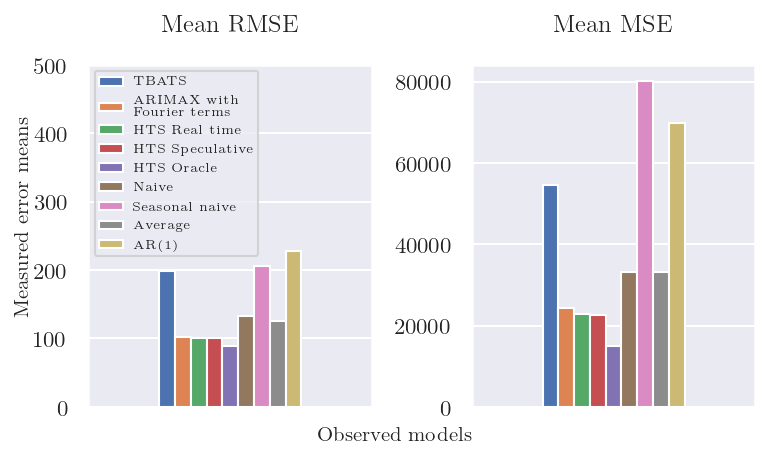

In [12]:
fig, ax = plt.subplots(1, 2, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=3)

#fig.set_size_inches(8, 4)



results[['mean_tbats_rmse', 'mean_arimax_rmse','mean_total_rt_rmse',
         'mean_total_speculative_rmse', 'mean_oracle_rmse',
         'mean_naive_rmse', 'mean_seasonal_naive_rmse',
         'mean_average_rmse', 'mean_ar1_rmse']].plot(kind='bar', ax=ax[0])#, color=sns.color_palette("muted", n_colors=8))

ax[0].set_title("Mean RMSE", pad=16)

ax[0].get_xaxis().set_ticks([])
#ax[0].set_xlabel("Models")


ax[0].set_ylim(ymax=500)


results[['mean_tbats_mse', 'mean_arimax_mse', 'mean_total_rt_mse',
         'mean_total_speculative_mse', 'mean_oracle_mse',
         'mean_naive_mse', 'mean_seasonal_naive_mse',
         'mean_average_mse', 'mean_ar1_mse' 
        ]].plot(kind='bar', ax=ax[1])

ax[1].set_title("Mean MSE", pad=16)
ax[1].get_legend().remove()
            
ax[0].legend(["TBATS", "ARIMAX with\nFourier terms", 'HTS Real time',
              'HTS Speculative',  'HTS Oracle',
              "Naive", "Seasonal naive",
              "Average", 'AR(1)'], fontsize="xx-small", loc='upper left')
            
ax[1].get_xaxis().set_ticks([])
#ax[1].set_ylim(ymax=40000000)
#ax[1].set_xlabel("Models")

fig.text(0.5, 0.004, 'Observed models', ha='center')
fig.text(0.004, 0.5, 'Measured error means', va='center', rotation='vertical')


fig.savefig('../../plots/text-plots/8-1min-hts-combined-rmse.pgf')

In [124]:
1 - (results['mean_oracle_rmse'] / results['mean_total_rt_rmse'])

0    0.146866
dtype: float64

In [155]:
1 - (results['mean_oracle_mse'] / results['mean_total_rt_mse'])

0    0.335526
dtype: float64